# Test loading elevation maps

Goal is to capture all of the data in the maps, with NaNs when missing, and have a grid rotated alongshore to facilitate erosion calcs.

TODO:
* Make a rotated grid big enough to accomodate all of the maps. What resolution?
* Assign UTM values to for rotated grid.
* Load each map, [smooth?], and interpolate onto rotated grid.
* Stack all maps. Work in rotated grid coordintes.
* Save
    

In [1]:
import json
import fiona
import numpy as np
import pandas as pd
import scipy.signal
from IPython.display import display, HTML
import rasterio # rasterio and OGR don't mix...see rasterio docs
from rasterio import Affine
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [2]:
fdir = "F:/2017_Karen_Sandwich_maps"
#fdir = "C:/crs/proj/2017_Karen_Sandwich_maps"

fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
#"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\ # needs to be padded...not very good control
"2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif",\
"DEM_10cm_selfcal_lokicampos_mid_denseNAD83UTM19.tif")

dslist =[]
# just read one for now (note...this reads in as a DataArray, not a DataSet)
fn = fdir+"/2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif"
# fn = fdir+"/2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif"

da = xr.open_rasterio(fn)
#     ds = ds.sel(x=slice(e0,e1), y=slice(n0,n1))
#     if len(dslist) == 0:
#         xc = ds['x']-ds['x'].values.min()
#         yc = ds['y']-ds['y'].values.min()
#     ds['x'] = xc
#     ds['y'] = yc
#     dslist.append(ds)

In [3]:
# look to see what got loaded
print(da['x'].values[0], da['x'].values[-1], da['y'].values[0], da['y'].values[-1])
# this is super slow and only successfully returns min and max
# print(stats.describe(da.values,nan_policy='omit'))
print(da.values.min(), da.values.max())
print(da.sizes)
print(da.dims)
print(da.indexes)
da.values

376286.692999 377485.292999 4625440.78441 4624418.28441
-32767.0 14.8271
Frozen(OrderedDict([('band', 1), ('y', 10226), ('x', 11987)]))
('band', 'y', 'x')
band: Int64Index([1], dtype='int64', name='band')
y: Float64Index([ 4625440.784410301,    4625440.6844103, 4625440.5844103005,
                  4625440.484410301,    4625440.3844103,  4625440.284410301,
                    4625440.1844103, 4625440.0844103005,  4625439.984410301,
                    4625439.8844103,
                 ...
                    4624419.1844103, 4624419.0844103005,  4624418.984410301,
                    4624418.8844103,  4624418.784410301,    4624418.6844103,
                 4624418.5844103005,  4624418.484410301,    4624418.3844103,
                  4624418.284410301],
                dtype='float64', name='y', length=10226)
x: Float64Index([376286.69299908396,   376286.792999084, 376286.89299908397,
                 376286.99299908394,   376287.092999084, 376287.19299908396,
                   376287.

array([[[-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        ..., 
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.],
        [-32767., -32767., -32767., ..., -32767., -32767., -32767.]]], dtype=float32)

Example from scipy.interpolate.RegularGridInterpolator documentation
```
def ff(x,y):
...     return 2 * x**3 + 3 * y**2
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
data = ff(*np.meshgrid(x, y, indexing='ij', sparse=True))
print(np.shape(x),np.shape(y),np.shape(data))

f = interpolate.RegularGridInterpolator( (x, y), data, method='nearest')
```

In [4]:
from scipy import interpolate
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)
# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
z = np.flipud(np.squeeze(da.values))

# smooth with 2D running median
zs = scipy.signal.medfilt2d(z, kernel_size=3)

print(np.shape(x),np.shape(y),np.shape(zs))
f = interpolate.RegularGridInterpolator( (y, x), zs, method='nearest')

(10226,) (11987,) (1, 10226, 11987)
(11987,) (10226,) (10226, 11987)


In [130]:
# make a small box w/ 0.5m grid
dxy = 1.
xmax = 250.
ymax = 3000.
nx = int((1./dxy)*xmax) + 1
ny = int((1./dxy)*ymax) + 1
xrot, yrot=np.meshgrid(np.linspace(0.,xmax,nx), np.flip(np.linspace(0.,ymax,ny),0) ,sparse=False, indexing='xy')
print(xrot.shape)
xrot
print(yrot.shape)
yrot

(3001, 251)
(3001, 251)


array([[  3.00000000e+03,   3.00000000e+03,   3.00000000e+03, ...,
          3.00000000e+03,   3.00000000e+03,   3.00000000e+03],
       [  2.99900000e+03,   2.99900000e+03,   2.99900000e+03, ...,
          2.99900000e+03,   2.99900000e+03,   2.99900000e+03],
       [  2.99800000e+03,   2.99800000e+03,   2.99800000e+03, ...,
          2.99800000e+03,   2.99800000e+03,   2.99800000e+03],
       ..., 
       [  2.00000000e+00,   2.00000000e+00,   2.00000000e+00, ...,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [131]:
# calculate UTM coordinates for the box, which depend on upper left hand corner and rotation

# top left corner of big region of interest (UTM Zone 19N meters)
e0 = 376300.; n0 = 4625250.
rot = 98.
def box2UTM(x, y, e0, n0, rot):
    r = np.pi*(rot-90.)/180.
    xnew = x*np.cos(r)   + y*np.sin(r) + e0
    ynew = -y*np.sin(r)  + x*np.cos(r) + n0
    return xnew, ynew

xu, yu = box2UTM(xrot, yrot, e0, n0, rot)

print('Data box:')
print(da['x'].values.min(), da['x'].values.max(), da['y'].values.min(), da['y'].values.max())
print('Interp. box:')
print(np.min(xu),np.max(xu),np.min(yu),np.max(yu))

xb, yb = np.array((xrot.min(),xrot.min(),xrot.max(),xrot.max())), np.array((yrot.min(),yrot.max(),yrot.min(),yrot.max()))
xub, yub = box2UTM(xb, yb, e0, n0, 120.)
fid = open('box_corners.txt','w')
for i in range(0,4):
    fid.write('{0:}, {1:}\n'.format( xub[i],yub[i]))
fid.close()

Data box:
376286.692999 377485.292999 4624418.28441 4625440.78441
Interp. box:
376300.0 376965.08632 4624832.4807 4625497.56702


In [132]:
#plt.scatter(xu, yu, marker='.')

In [133]:
from scipy import interpolate
print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
x = da['x'].values
y = np.flipud(da['y'].values)
# Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
# However, make sure to squeeze before flipping
z = np.flipud(np.squeeze(da.values))
print(np.shape(x),np.shape(y),np.shape(z))
f = interpolate.RegularGridInterpolator( (y, x), z, method='linear')

(10226,) (11987,) (1, 10226, 11987)
(11987,) (10226,) (10226, 11987)


In [134]:
# z[z<=-100.]=np.NaN
# plt.pcolormesh(x,y,z)
# plt.colorbar()
np.shape(xu)

(3001, 251)

%%time
zi = f((yu,xu))
zi[zi<=-100.]=np.NaN

In [135]:
%%time
zi=np.NaN*np.ones((ny,nx))
# this is a slow iteration through all of the points, but allows us to skip ones that are outside
for i in np.ndindex(zi.shape):
    try:
        zi[i]=f((yu[i],xu[i]))
    except:
        zi[i]=np.NaN
     

Wall time: 1min 28s


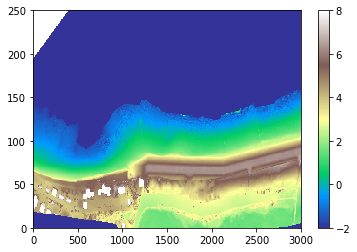

In [136]:
plt.plot(figsize=(2,8))
plt.pcolormesh(yrot,xrot,zi,cmap=plt.cm.terrain,vmin=-2,vmax=8)
#plt.gca().invert_yaxis()
#plt.axis('equal')
plt.ylim(0,250)
plt.colorbar()

(3001, 251)


(-2, 8)

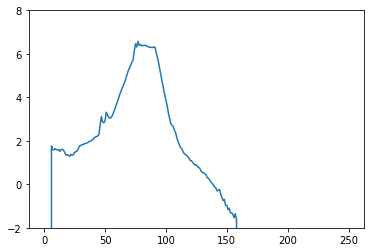

In [139]:
print(np.shape(zi))
plt.plot(zi[0,:])
plt.ylim(-2,8)